In [10]:
import glob
import random
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torchvision.transforms
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from segnet import SegNet

In [11]:
use_cuda = torch.cuda.is_available()

def get_variable(x):
    """ Converts tensors to cuda, if available. """
    if use_cuda:
        return x.cuda()
    return x


def get_numpy(x):
    """ Get numpy array for both cuda and not. """
    if use_cuda:
        return x.cpu().data.numpy()
    return x.data.numpy()

In [12]:
if use_cuda:
    from google.colab import drive
    drive.mount('/content/drive')

In [13]:
if use_cuda:
    path_to_images = '/content/drive/My Drive/train/raw_images'
    path_to_annotations = '/content/drive/My Drive/train/annotations_white'
else:
    path_to_images = 'train/raw_images'
    path_to_annotations = 'train/annotations_white'

transform_pipe = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(), # Convert np array to PILImage
    
    torchvision.transforms.RandomCrop(size=(400, 400)),
    
    torchvision.transforms.RandomHorizontalFlip(0.5),
    
    torchvision.transforms.RandomVerticalFlip(0.5),
    
    torchvision.transforms.ToTensor()
])

# Unet resize transform
transform_resize = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(), # Convert np array to PILImage
    
    torchvision.transforms.Resize((116, 116)),
    
    torchvision.transforms.ToTensor()
])

data_norm = torchvision.transforms.Normalize(mean=[0.78092086, 0.5018261, 0.7803567],
                                 std=[0.16727196, 0.24176046, 0.13103652])
anno_norm =  torchvision.transforms.Normalize(mean=[0.00202586], std=[0.00176733])


class CustomDataset(Dataset):
    
    def __init__(self, img_list, anno_list, num_of_classes=2, transform=None):
        
        self.img_list = img_list
        self.anno_list = anno_list
        self.num_of_classes = num_of_classes
        self.transform = transform
        
    def __getitem__(self, img_id):
        
        image = Image.open(img_list[img_id])
        img = np.array(image)
        anno = np.array(Image.open(self.anno_list[img_id]).convert("L"))
        
        seed = np.random.randint(2147483647)
        random.seed(seed)
        if self.transform:
            img = self.transform(img)
            # img = data_norm(img)
            random.seed(seed)
            anno = self.transform(anno)
#           anno = transform_resize(anno)     # unet resize
#             anno = anno_norm(anno)
    
#         anno[anno > 0] = 1      
        sample = {"image": img, "annotation": anno}
        return sample
    
    
    def __len__(self):
        return len(self.img_list)

img_list = glob.glob(path_to_images + os.sep + "*.bmp")
img_list = sorted(img_list)
anno_list = glob.glob(path_to_annotations + os.sep + "*.bmp")
anno_list = sorted(anno_list)
dataset_train = CustomDataset(img_list, anno_list, 2, transform=transform_pipe)


In [14]:
dataloader_train = torch.utils.data.DataLoader(
    dataset_train,
    batch_size = 3,
    shuffle=True
)

(3, 3, 400, 400)


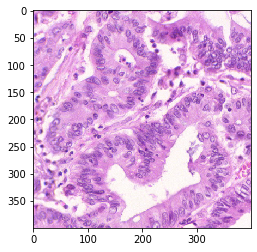

torch.Size([3, 1, 400, 400])


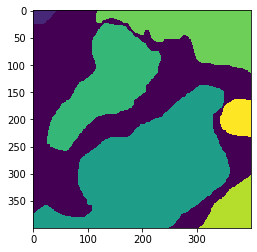

In [15]:
data = [batch_data for batch_data in dataloader_train]
batch_data = data[0]
fig_img = plt.figure()
print(batch_data['image'].numpy().shape)
plt.imshow(batch_data['image'][0].permute(1, 2, 0).numpy())
plt.show()
print(batch_data['annotation'].shape)
batch_data['annotation'] = batch_data['annotation']
plt.imshow(batch_data['annotation'][0][0])
fig_img.suptitle('image')
plt.show()

In [16]:
net = SegNet(3, 1) # input channels, output channels
if use_cuda:
    net.cuda()

In [17]:
LEARNING_RATE = 0.001
# criterion = nn.CrossEntropyLoss() for multiple class
criterion = nn.BCEWithLogitsLoss() 

# optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)
optimizer = optim.SGD(net.parameters(), LEARNING_RATE, momentum=0.9, weight_decay=5e-4)
# optimizer = optim.Adam(net.parameters(), 1e-3, (0.9, 0.999),  eps=1e-08, weight_decay=1e-4)

train loss:  0.5146493911743164
train loss:  0.38736602663993835
train loss:  0.22359609603881836
train loss:  0.11266016215085983
train loss:  0.08326467126607895
train loss:  0.08899101614952087


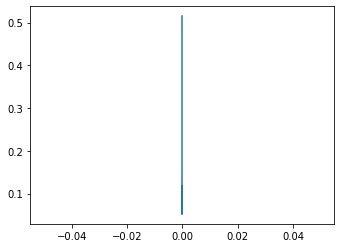

Train, it: 0 loss: 0.11
train loss:  0.06531395018100739
train loss:  0.08859484642744064
train loss:  0.049053169786930084


KeyboardInterrupt: 

In [20]:
max_iter = 5
log_every = 100
eval_every = 100

# Initialize lists for training and validation
train_iter = []
train_loss, train_accs = [], []
valid_iter = []
valid_loss, valid_accs = [], []

# Train network
net.train()
for i in range(max_iter):
    for j, batch_train in enumerate(dataloader_train):
        # Train
        inputs = get_variable(Variable(batch_train['image']))
        anno = get_variable(Variable(batch_train['annotation']))
        output = net(inputs)
        batch_loss = criterion(output, anno)

        train_iter.append(i)
        b_loss = float(get_numpy(batch_loss))
        train_loss.append(b_loss)
        
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        
        if j % 5 == 0:
            print("train loss: ", train_loss[-1])

    fig = plt.figure(figsize=(12,4))
    plt.subplot(1, 2, 1)
    plt.plot(train_iter, train_loss, label='train_loss')
#     plt.plot(valid_iter, valid_loss, label='valid_loss')
    plt.show()

#     plt.subplot(1, 2, 2)
#     plt.plot(train_iter, train_accs, label='train_accs')
#     plt.plot(valid_iter, valid_accs, label='valid_accs')
#     plt.legend()
#     plt.show()
#         clear_output(wait=True)
    print("Train, it: {} loss: {:.2f}".format(i, train_loss[-1]))


input shape: torch.Size([3, 3, 400, 400])


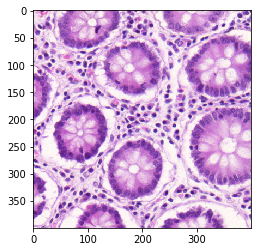

anno shape: torch.Size([3, 1, 400, 400])
tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],


        [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],


        [[[0.0078, 0.0078, 0.0078,  ..., 0.0157, 0.0000, 0.0000],
          [0.0078, 0.0078, 0.0078,  ..., 0.0157, 0.0000, 0.0000

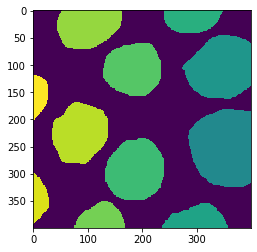

output shape: torch.Size([3, 1, 400, 400])
tensor([[[[-1.1115, -1.5967, -1.9749,  ..., -2.2104, -2.0567, -0.6395],
          [-1.4605, -2.6501, -3.7564,  ..., -2.7242, -2.9494, -1.6280],
          [-1.8321, -2.7023, -3.3815,  ..., -3.0956, -2.6053, -1.5421],
          ...,
          [-1.7108, -2.4027, -2.9065,  ..., -2.8346, -2.2520, -1.4462],
          [-1.5428, -2.4443, -2.7105,  ..., -2.3655, -2.5978, -1.4322],
          [-1.0547, -1.5200, -2.1216,  ..., -1.5363, -1.6254, -1.1524]]],


        [[[-1.1148, -1.7980, -2.1626,  ..., -1.6860, -1.4900, -0.8819],
          [-1.5317, -2.9238, -3.0571,  ..., -2.4979, -2.5395, -1.5489],
          [-1.6024, -2.4775, -3.6572,  ..., -2.9101, -2.6518, -1.8162],
          ...,
          [-1.7258, -2.3203, -3.2424,  ..., -2.5410, -2.8275, -1.6086],
          [-1.6607, -2.8716, -3.3361,  ..., -2.4268, -2.9075, -2.0577],
          [-0.9336, -1.4088, -2.2721,  ..., -1.5941, -1.7627, -1.2846]]],


        [[[-1.2476, -2.0903, -1.7667,  ..., -1.7085, -1

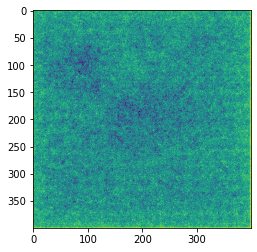

In [22]:
batch_data = data[1]
fig_img = plt.figure()
inputs = get_variable(Variable(batch_data['image']))
anno = batch_data['annotation']
output = net(inputs)
print('input shape:', inputs.shape)
plt.imshow(inputs[0].permute(1, 2, 0).numpy())
plt.show()
print('anno shape:', anno.shape)
print(anno)
plt.imshow(anno[0][0])
plt.show()
fig_img.suptitle('image')
print('output shape:', output.shape)
plt.imshow(get_numpy(output[0][0]))
print(output)
plt.show()

In [23]:
anno = get_variable(Variable(anno))
loss = criterion(output, anno)
print(get_numpy(loss))

0.062441867
